# Time Series Forecasting with RNNs
We'll be working with a preprocessed subset of this cinema ticket sales dataset from https://www.kaggle.com/datasets/arashnic/cinema-ticket. 


Preprocessed dataset: 
    - Filtering the dataset to a specific cinema
    - Removing any columns besides the total ticket sales through time (total_sales)
    - Splitting the data into training data (the first 67%) and testing data (the last 33%)
    - Scaling the ticket sales value to be between 0 and 1 based on the range of the training data

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np

In [2]:
def create_dataset(orig_dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(orig_dataset) - window_size - 1):
        window = orig_dataset.iloc[i:(i + window_size), 0]
        target = orig_dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

In [3]:
# Load the data
train = pd.read_csv("cinema_data_train.csv", index_col=0)
test = pd.read_csv("cinema_data_test.csv", index_col=0)

window_size = 1
X_train, y_train = create_dataset(train, window_size = window_size)
X_test, y_test = create_dataset(test, window_size = window_size)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [7]:
X_train.shape

(146, 1, 1)

In [10]:
# Define Model
model = tf.keras.Sequential()
model.add(layers.SimpleRNN(10, input_shape=(window_size, 1), activation='relu'))   #input_shape=(num_timesteps, num_features)
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model.fit(X_train, y_train)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [14]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))

-2.140991011618048


# Optimization - 
* LSTM
* Window size
* Number of hidden layers
* Number of nodes per hidden layer
* Type of recurrent layer (SimpleRNN, LSTM, GRU)
* Activation function used (or not) at each layer
* Optimizer
* Loss function

In [15]:
# Define Model
model = tf.keras.Sequential()
model.add(layers.LSTM(10, input_shape=(window_size, 1), activation='relu'))   #input_shape=(num_timesteps, num_features)
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 0s 2ms/step
-2.003107810035676


In [16]:
# OPtimization parameters
results_dict = {}

# num_hidden_layers
# nodes_hidden_layer
# Type of recurrent layer (SimpleRNN, LSTM, GRU)
# Activation function used (or not) at each layer
# Optimizer
# Loss function

window_size = [3,5,7,9,12]

for w in window_size:
    X_train, y_train = create_dataset(train, w)
    X_test, y_test = create_dataset(test, w)

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    model = tf.keras.Sequential()
    model.add(layers.LSTM(128, input_shape=(1, w), activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    model.fit(X_train, y_train, epochs=50)

    y_pred = model.predict(X_test)

    print(f"R-Squared on test set: {r2_score(y_test, y_pred)}")
    model.summary()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_dict[f'window_size-{w}'] = r2_score(y_test, y_pred)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 77,953
Trainable params: 77,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 1s 4ms/step - loss: 0.1823
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 0.1530
Epoch 3/50
5/5 [============

In [17]:
results_dict

{'window_size-3': 0.2937198996848427,
 'window_size-5': 0.5790224440779612,
 'window_size-7': 0.6254549237120177,
 'window_size-9': 0.6522280616034346,
 'window_size-12': 0.6091921156676845}

# Loading and Scaling the raw Data & Plot

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Load the full dataset
total_df = pd.read_csv("cinema_data.csv", index_col=0)

# Split data into train and test sets using 2:1 ratio
train_size = int(len(total_df) * 0.67)
train_df = total_df.iloc[0:train_size, :]
test_df = total_df.iloc[train_size:len(total_df), :]

# Instantiate scaler object and fit to the training set
scaler = MinMaxScaler()
scaler.fit(train_df)

# Scale train and test datasets based on the train dataset
# It's critical that we scale the test set using the same scaler object
train = pd.DataFrame(scaler.transform(train_df), columns=['total_sales'], index=train_df.index)
test = pd.DataFrame(scaler.transform(test_df), columns=['total_sales'], index=test_df.index)

X_train, y_train = create_dataset(train, 9)
X_test, y_test = create_dataset(test, 9)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

window_size = 9

model = tf.keras.Sequential()
model.add(layers.LSTM(128, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(X_train, y_train, epochs=50)

y_pred = model.predict(X_test)

print(f"R-Squared on test set: {r2_score(y_test, y_pred)}")
model.summary()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# results_dict[f'window_size-{w}'] = r2_score(y_test, y_pred)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               70656     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 81,025
Trainable params: 81,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 1s 4ms/step - loss: 0.1739
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 3/50
5/5 [============

2/2 [==============================] - 0s 3ms/step


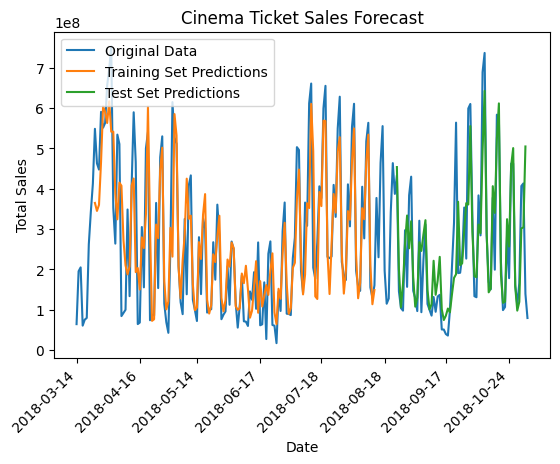

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make predictions on train and test data
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Un-scale the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Load in the original data (for comparison)
baseline = pd.read_csv("cinema_data.csv", index_col=0)

# Un-window the training predictions
plot_train_pred = np.empty((len(baseline), 1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(baseline), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + (window_size * 2) + 1:len(baseline) - 1, :] = test_pred

# Plot the original data
plt.plot(baseline, label="Original Data")

# Plot the predictions
plt.plot(plot_train_pred, label="Training Set Predictions")
plt.plot(plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('Cinema Ticket Sales Forecast')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.legend()